# Reinforcement Learning Open Source Fest
**Pre-Screening Excercise** <br>

by **Nihal D'Souza** <br>
**nihaldsouza1@gmail.com** <br>

---

## Table of Contents 
* Context Information
* Getting started
* Simulating Reward for Vowpal Wabbit
* Understanding Vowpal Wabbit format
* Getting a decision from Vowpal Wabbit
* Reinforcement learning simulation
* First scenario
* Second scenario
* Reward Incrementer (RI) 
    - Varying reward distribution over time
    - Testing over a range of RI values
    - Visualizing the policy prediction process
* Exploration Algorithms
    - Epsilon-Greedy 
    - Explore First
    - Softmax Explorer
    - Bagging Explorer

## Context Information
<div>
<img src="cost_func_table.png" width="500"/>
</div>

## Getting Started

In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

## Simulating reward for Vowpal Wabbit

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [4]:
#Define get_cost function
def get_cost(context, action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == "politics":
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == "music":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    if context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == "sports":
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == "politics":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

## Understanding Vowpal Wabbit format

In [5]:
#Covert to vw format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [6]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


## Getting a decision from Vowpal Wabbit

In [7]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [8]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

## Reinforcement learning simulation

In [9]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [10]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = get_cost(context, action)
        cost_sum += cost
        
        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)
    print("Average CTR: ", -1*cost_sum/(num_iterations))
    return ctr

In [11]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('iterations')
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# First Scenario

Average CTR:  0.8028


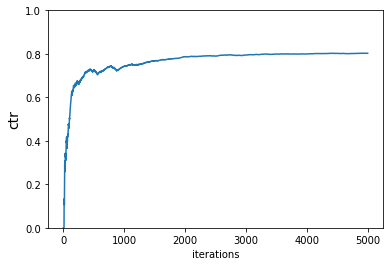

In [12]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

Average CTR:  0.1456


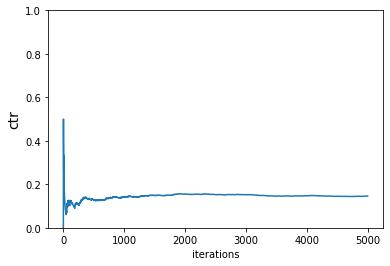

In [13]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

# Second Scenario

In [14]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [15]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    print("Average CTR: ", -1*cost_sum/(num_iterations*len(cost_functions)))
    return ctr

Average CTR:  0.8034


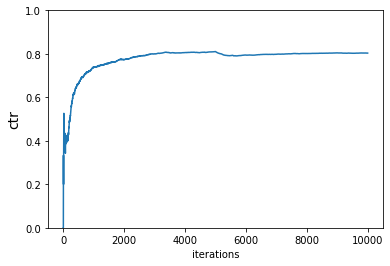

In [16]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Average CTR:  0.1424


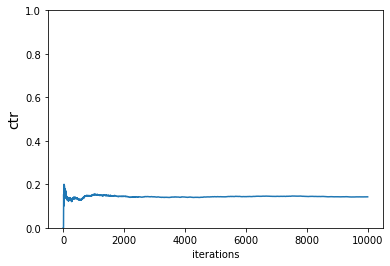

In [17]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Rewards Incrementer (RI)

The basic idea behind the 'rewards incrementer' simulator is to increase the reward size in comparitively small increments with **every successive reward** it gains. The expected outcome being the VW model would observe this lucrative pattern and insinctively become ever so slightly greedy. 

### Varying reward distribution over time

The RI simulator is mostly similar to the one introduced in the second scenario with a few additions to account for the RI logic:
* In step 4, we check if the cost obtained for the predicted action is a loss (0) or a reward (-1)
    - If reward (cost == -1)
        - Increment the obtained cost by the RI value
        - Increment the RI value by itself (for the next successive reward)
        - Increment the cost sum by -1 (To calculate the average CTR)
    - If loss (cost == 0)
        - Reset the RI value to the original value
* We also record the context and action for every iteration (record_info) to later visualize the prediction process
    

In [27]:
def run_simulation_with_rewards_incrementer(vw, num_iterations, users, times_of_day, actions, cost_functions, rewards_increment, do_learn = True, disp_avg_ctr=False):
    cost_sum = 0.
    ctr = []
    
    record_info = {"Tom":{"iterations":[], "action":[], "time_of_day":[]}, "Anna":{"iterations":[], "action":[], "time_of_day":[]}}
    
    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        current_increment_value = rewards_increment
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)
            
            #Lets record the context along with the action taken by the model for each iteration
            record_info[context['user']]['iterations'].append(i)
            record_info[context['user']]['action'].append(action)
            record_info[context['user']]['time_of_day'].append(context['time_of_day'])

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            # cost equal to -1 indicates a reward. With every successive reward, the reward value is incremented by the value specified by 'rewards_increment'
            if cost == -1:
                cost = cost+current_increment_value
                current_increment_value += rewards_increment
                cost_sum -= 1 # Adding -1 to the cost sum for every iteration that results in a reward to later calculate the average CTR
            # cost equal to 0 indicates no reward. If there was a successive run of rewards previously, a 'no rewards' action breaks the streak and sets the 'current_increment_value' back to the original 'rewards_increment' value
            elif cost == 0:
                current_increment_value = rewards_increment

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    if disp_avg_ctr:
        print("Average CTR: ", -1*cost_sum/(num_iterations*len(cost_functions)), "when succesive rewards are incremented by ", rewards_increment)
    return ctr, record_info

### Testing over a range of RI values
* Now that we have defined our RI simulator, let us test it using the Epsilon-Greedy algorithm, setting the Epsilon value as 0.2
* We shall test this simulator over a range of RI values, keeping the same 2 cost functions from earlier and the total number of interations as 10000 (5000 per cost function).

In [28]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
rewards_increment_values = [-1e-07, -1e-05, -1e-03, -0.1, -1, -5]
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)
ctr_reward_list = []
record_info_list = []

for rew in rewards_increment_values:
    ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, 
                                                               cost_functions, rew, disp_avg_ctr=True)
    ctr_reward_list.append(ctr)
    record_info_list.append(record_info)
    

Average CTR:  0.7987 when succesive rewards are incremented by  -1e-07
Average CTR:  0.7887 when succesive rewards are incremented by  -1e-05
Average CTR:  0.7669 when succesive rewards are incremented by  -0.001
Average CTR:  0.7452 when succesive rewards are incremented by  -0.1
Average CTR:  0.7069 when succesive rewards are incremented by  -1
Average CTR:  0.6292 when succesive rewards are incremented by  -5


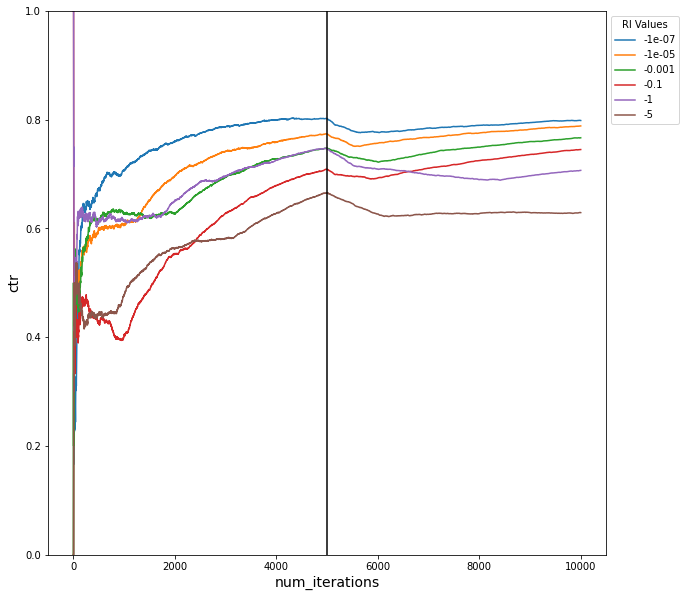

In [29]:
plt.figure(figsize=(10,10))
plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([0,1])
for ctr_mod in ctr_reward_list:
    plt.plot(range(1,total_iterations+1), ctr_mod)
plt.axvline(x=total_iterations/2, color='black')
plt.legend(rewards_increment_values, bbox_to_anchor=(1, 1), title="RI Values")
plt.show()

#### Observations
* The above graph showcases an interesting trend with a steady drop in the average CTR with an increase in the successive RI value.
* One would imagine that greater the successive RI, the greater the incentive for the policy to choose a particular action. But the outcome is quite the opposite.
* Another interesting, yet an expected outcome is the drop in CTR when the new cost function is introduced (immediately after the centre black line at 5000 iterations). A larger RI value seems to experience a greater drop in CTR. This could be because as the policy learns to predict the new context, the initial exploration phase results in a greater cost delta with an increasing RI value. 

### Visualizing the policy prediction process
* While implementing the first and second scenarios, I wondered "What does the policy predict at every iteration?" and "What actions are the policy predicting when the learning is enabled vs. when it is disabled?"
* To answer both these questions, I decided to visualize the selection process for both Tom and Anna's preferences

In [30]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
reward_incrementer_value = -1e-07

# Learning enabled
ctr_l, record_info_l = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, reward_incrementer_value, do_learn=True)

#Learning Disabled
ctr_nl, record_info_nl = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, reward_incrementer_value, do_learn=False)

In [31]:
#Map the time of day to a color for visualization
def color_time_of_day_map(tod):
    if tod == "morning":
        return 0
    elif tod == "afternoon":
        return 1

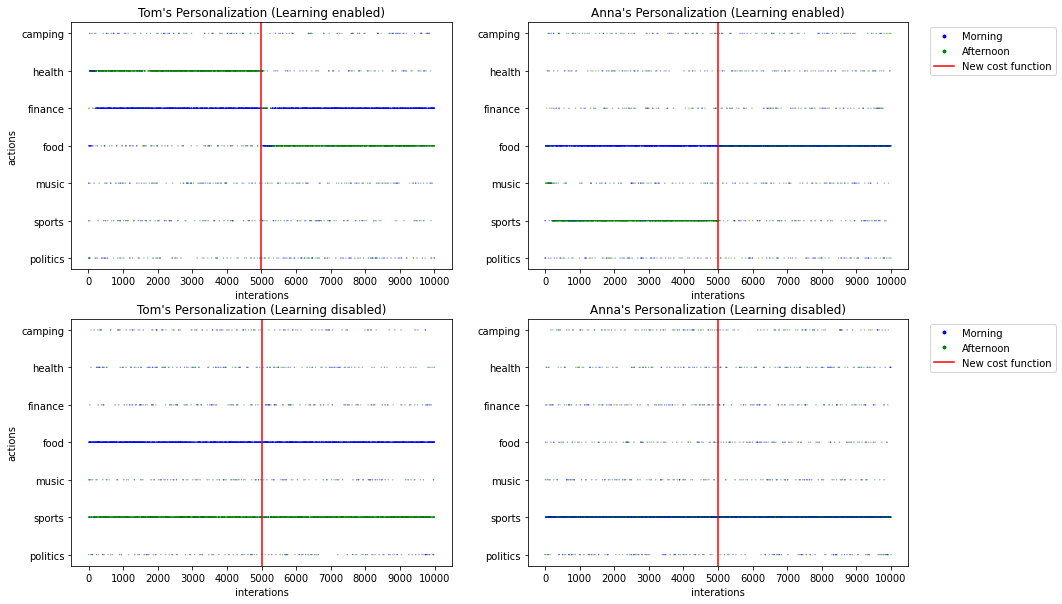

In [32]:
#Side-by-side comparision of Tom's and Anna's Personalization
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

plt.figure(figsize=(15,10))
colours = ListedColormap(['b','g'])
classes=["morning", "afternoon"]
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), 
                   Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5),
                  Line2D([1], [1], color='red', label='New cost function', markerfacecolor='red', markersize=5)]

plt.subplot(221)
plt.title('Tom\'s Personalization (Learning enabled)')
plt.xlabel('interations')
plt.ylabel('actions')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.axvline(x=total_iterations/2, color='r')
plt.scatter(record_info_l['Tom']['iterations'], record_info_l['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_l['Tom']['time_of_day']], cmap=colours, s=.05)

plt.subplot(222)
plt.title('Anna\'s Personalization (Learning enabled)')
plt.xlabel('interations')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.scatter(record_info_l['Anna']['iterations'], record_info_l['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_l['Anna']['time_of_day']], cmap=colours, s=.05)
plt.axvline(x=total_iterations/2, color='r')
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))

plt.subplot(223)
plt.title('Tom\'s Personalization (Learning disabled)')
plt.xlabel('interations')
plt.ylabel('actions')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.axvline(x=total_iterations/2, color='r')
plt.scatter(record_info_nl['Tom']['iterations'], record_info_nl['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_nl['Tom']['time_of_day']], cmap=colours, s=.05)

plt.subplot(224)
plt.title('Anna\'s Personalization (Learning disabled)')
plt.xlabel('interations')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.scatter(record_info_nl['Anna']['iterations'], record_info_nl['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_nl['Anna']['time_of_day']], cmap=colours, s=.05)
plt.axvline(x=total_iterations/2, color='r')
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))

plt.show()


#### Observations
* A noticiable distinction between when the learning is enabled vs disabled is the ability of the VW policy to react to a change in context when a new cost function is introduced. This is expected as the VW policy **does not recieve any feedback** from the previous iteration when the learning is disabled.
* Another noticable observation is in both cases (learning enabled and disabled), **the exploration process never stops.** Despite the VW policy predicting a certain action for a given context for the most part, there is evidence of it also predicting other actions too, albeit less frequently.

## Exploration Algorithms
##### We will be using the custom 'reward incrementer' as the default simulator to test and compare different models. 

### Epsilon-Greedy
* Let us begin with the Epsilon-Greedy as it is the default exploration algorithm.
* A higher epsilon value indicates a higher tendency to explore. Which means the policy would most probably chose an action at random to improve the accuracy of the estimated action-values and hence improve decision making for the future.
* A lower epsilon value on the other hand would tend the policy towards exploitation aka the greedy method. It would choose an action that would most likely give it a reward. This might be detrimental in the long run when trying to find the optimal action-values.

In [33]:
#Function to generate 2x2 subplots between the ctr value and chosen action over the iterations
def vis_eg(ctr1, ctr2, record_info_1, record_info_2, title1, title2, actions, total_iterations):
    plt.figure(figsize=(15,15))
    colours = ListedColormap(['b','g'])
    classes=["morning", "afternoon"]
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), 
                       Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5),
                      Line2D([1], [1], color='red', label='New cost function', markerfacecolor='red', markersize=5)]
    
    plt.subplot(321)
    plt.title(title1)
    plot_ctr(total_iterations, ctr1)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(322)
    plt.title(title2)
    plot_ctr(total_iterations, ctr2)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(323)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization (Epsilon = 0.1)")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Tom']['iterations'], record_info_1['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Tom']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(324)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization (Epsilon = 0.9)")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_2['Tom']['iterations'], record_info_2['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Tom']['time_of_day']], cmap=colours, s=.05)
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))
    
    plt.subplot(325)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization (Epsilon = 0.1)")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Anna']['iterations'], record_info_1['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(326)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization (Epsilon = 0.9)")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_2['Anna']['iterations'], record_info_2['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Anna']['time_of_day']], cmap=colours, s=.05)
#     plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1))
    
    plt.show()

#### Comparing epsilon values 
* Comparing a low and high *epsilon* value, while keeping the rest of the hyperparameter values intact. RI is set to -1e-07

In [34]:
num_iterations_per_cost_func = 5000
rewards_increment = -1e-07
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

vw_eg_low = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")
ctr_eg_low, record_info_eg_low = run_simulation_with_rewards_incrementer(vw_eg_low, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)
title_eg_low = "Low Epsilon Value (0.1)"

vw_eg_high = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.9")
ctr_eg_high, record_info_eg_high = run_simulation_with_rewards_incrementer(vw_eg_high, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)
title_eg_high = "High Epsilon Value (0.9)"


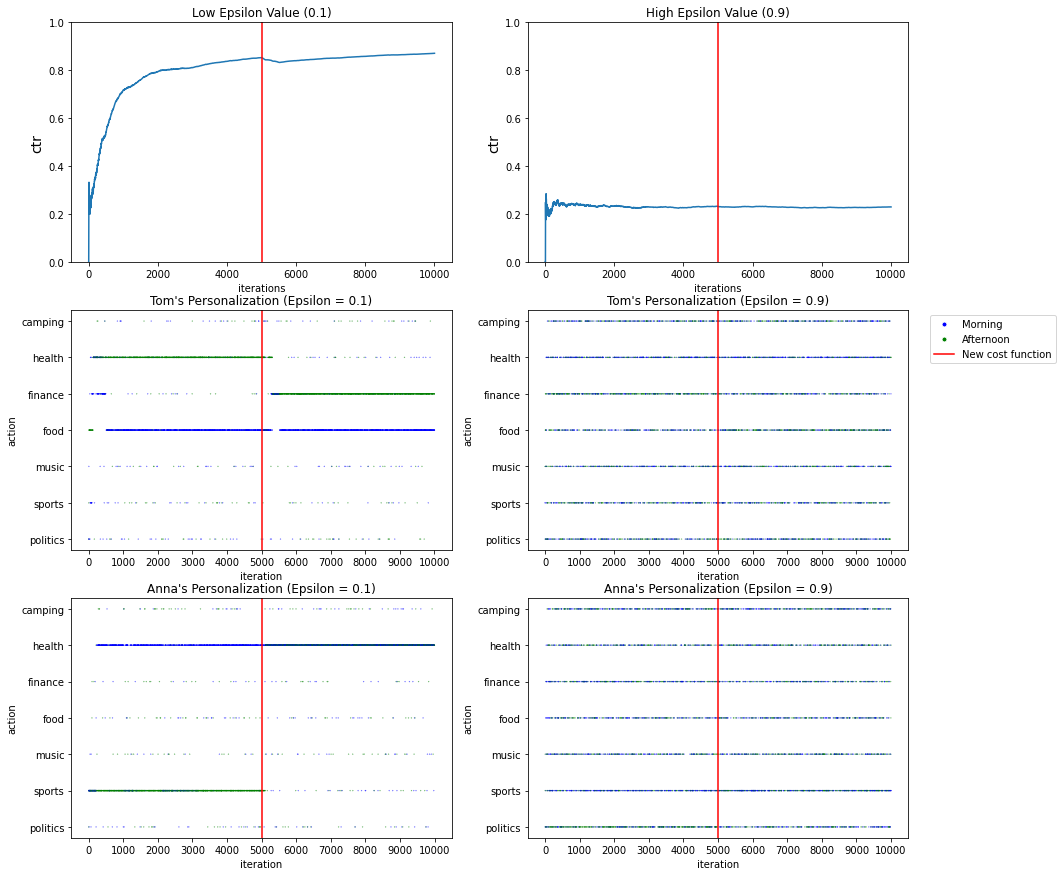

In [35]:
vis_eg(ctr_eg_low, ctr_eg_high, record_info_eg_low, record_info_eg_high, title_eg_low, title_eg_high, actions, total_iterations)

### Observations
* As expected, a low epsilon value favours exploitation and therefore is a lot more resilient to sparse prediction. From the illustrations of Tom's and Anna's personalization with a low Epsilon value, we observe the clear bias towards certain actions.
* On the other hand, a high epsilon value results in a highly volatile prediction process. This is evident as there is no clear bias being showcased in either Tom or Anna's personalization, resulting in poor performace.
* A good Epsilon value would balance these two extremes, allowing for a fair share of exploration and a clear bias towards a high reward outcome.

### 2 b. Explore First
The idea behind explore first is to try each action uniformly for *tau* number of times, and then then choose/exploit the action with the highest average reward over the remaining iterations.



In [36]:
def vis_ef(ctr1, ctr2, record_info_1, record_info_2, title1, title2, tau_1, tau_2, actions, total_iterations):
    plt.figure(figsize=(15,15))
    colours = ListedColormap(['b','g'])
    classes=["morning", "afternoon"]
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), 
                       Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5),
                      Line2D([1], [1], color='red', label='New cost function', markerfacecolor='red', markersize=5),
                      Line2D([1], [1], color='violet', label='End of exploration phase', markerfacecolor='red', markersize=5)]
    
    plt.subplot(321)
    plt.title(title1)
    plot_ctr(total_iterations, ctr1)
    plt.axvline(x=tau_1, color='violet')
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(322)
    plt.title(title2)
    plot_ctr(total_iterations, ctr2)
    plt.axvline(x=tau_2, color='violet')
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(323)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization (tau = "+str(tau_1)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=tau_1, color='violet')
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Tom']['iterations'], record_info_1['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Tom']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(324)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization (tau = "+str(tau_2)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.axvline(x=tau_2, color='violet')
    plt.scatter(record_info_2['Tom']['iterations'], record_info_2['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Tom']['time_of_day']], cmap=colours, s=.05)
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.55, 1))
    
    plt.subplot(325)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization (tau = "+str(tau_1)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=tau_1, color='violet')
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Anna']['iterations'], record_info_1['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(326)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization (tau = "+str(tau_2)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.axvline(x=tau_2, color='violet')
    plt.scatter(record_info_2['Anna']['iterations'], record_info_2['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.show()

#### Comparing tau values 
* Comparing a low and high *tau* value, while keeping the rest of the hyperparameter values intact. RI is set to -1e-07

In [37]:
num_iterations_per_cost_func = 5000
rewards_increment = -1e-07
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

low_tau_value = 50
vw_ef_low = pyvw.vw("--cb_explore_adf -q UA --first "+str(low_tau_value))
ctr_ef_low, record_info_ef_low = run_simulation_with_rewards_incrementer(vw_ef_low, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)
title_ef_low = "tau = " +str(low_tau_value)

high_tau_value = 1000
vw_ef_high = pyvw.vw("--cb_explore_adf -q UA --first "+str(high_tau_value))
ctr_ef_high, record_info_ef_high = run_simulation_with_rewards_incrementer(vw_ef_high, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)
title_ef_high = "tau = " +str(high_tau_value)


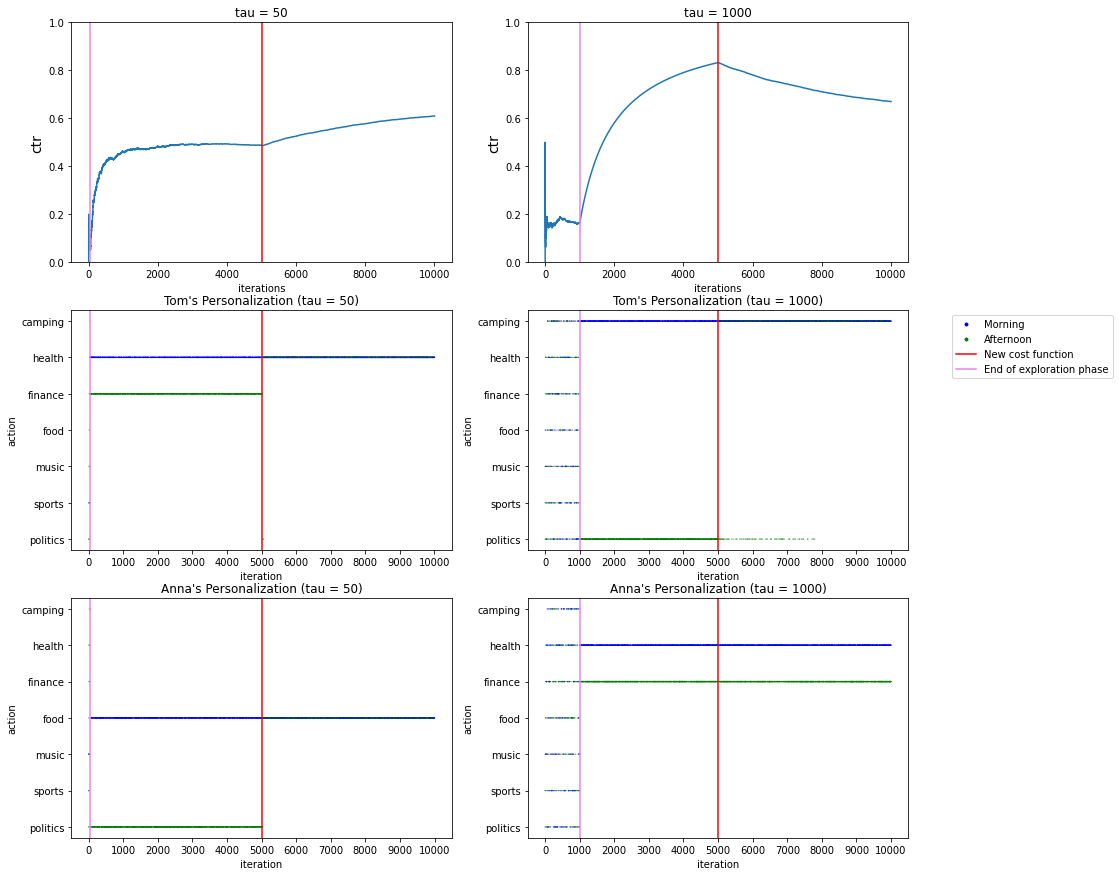

In [38]:
vis_ef(ctr_ef_low, ctr_ef_high, record_info_ef_low, record_info_ef_high, title_ef_low, title_ef_high, low_tau_value, high_tau_value, actions, total_iterations)

### Observations
* This algorithm clearly demarcates the exploration and exploitation phase as indicated by the pink vertical line. 
* For a higher *tau* value, we observe this more clearly as the iterations upto *tau* are quite sparse. 
* The performance here is better in the case of a higher *tau* value since we're allowing the policy more chances to explore all the rewards outcome over multiple passes resulting in a better average CTR.

### 2 c. Softmax Explorer
* Also known as **Boltzmann exploration**, instead of always taking the optimal action or taking an action at random, this approach involves choosing an action with weighted probabilities.
* Therefore in this case, the action the policy deems to be most optimal is **most likely (but not guaranteed)** to be chosen.
* This works out better than the e-greedy method because the information about the likely value of the other actions can also be taken into consideration. In this case, since there are 7 actions available to a policy, in e-greedy the 6 actions estimated to be non-optimal are all considered equally. But in Boltzmann exploration they are weighed by their relative value.
* This way the agent can ignore actions which it estimates to be largely sub-optimal and give more attention to potentially promising, but not necessarily ideal actions.

In [39]:
def vis_se(ctr1, ctr2, record_info_1, record_info_2, title1, title2, lambda_1, lambda_2, actions, total_iterations):
    plt.figure(figsize=(15,15))
    colours = ListedColormap(['b','g'])
    classes=["morning", "afternoon"]
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), 
                       Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5),
                      Line2D([1], [1], color='red', label='New cost function', markerfacecolor='red', markersize=5)]
    
    plt.subplot(321)
    plt.title(title1)
    plot_ctr(total_iterations, ctr1)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(322)
    plt.title(title2)
    plot_ctr(total_iterations, ctr2)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(323)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization (lambda = "+str(lambda_1)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Tom']['iterations'], record_info_1['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Tom']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(324)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization (lambda = "+str(lambda_2)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_2['Tom']['iterations'], record_info_2['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Tom']['time_of_day']], cmap=colours, s=.05)
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1))
    
    plt.subplot(325)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization (lambda = "+str(lambda_1)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Anna']['iterations'], record_info_1['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(326)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization (lambda = "+str(lambda_2)+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_2['Anna']['iterations'], record_info_2['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.show()

#### Comparing *lambda* values
* Comparing a low and high *lambda* value, while keeping the rest of the hyperparameter values intact. RI is set to -1e-07

In [40]:
num_iterations_per_cost_func = 5000
rewards_increment = -1e-07
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

low_lambda = 2
vw_se_low = pyvw.vw("--cb_explore_adf -q UA --softmax --lambda "+str(low_lambda))
ctr_se_low, record_info_low = run_simulation_with_rewards_incrementer(vw_se_low, num_iterations_per_cost_func, users, 
                                                              times_of_day, actions, cost_functions, rewards_increment)
vw_se_low_title = "Lambda = "+str(low_lambda)

high_lambda = 20
vw_se_high = pyvw.vw("--cb_explore_adf -q UA --softmax --lambda "+str(high_lambda))
ctr_se_high, record_info_high = run_simulation_with_rewards_incrementer(vw_se_high, num_iterations_per_cost_func, users, 
                                                              times_of_day, actions, cost_functions, rewards_increment)
vw_se_high_title = "Lambda = "+str(high_lambda)

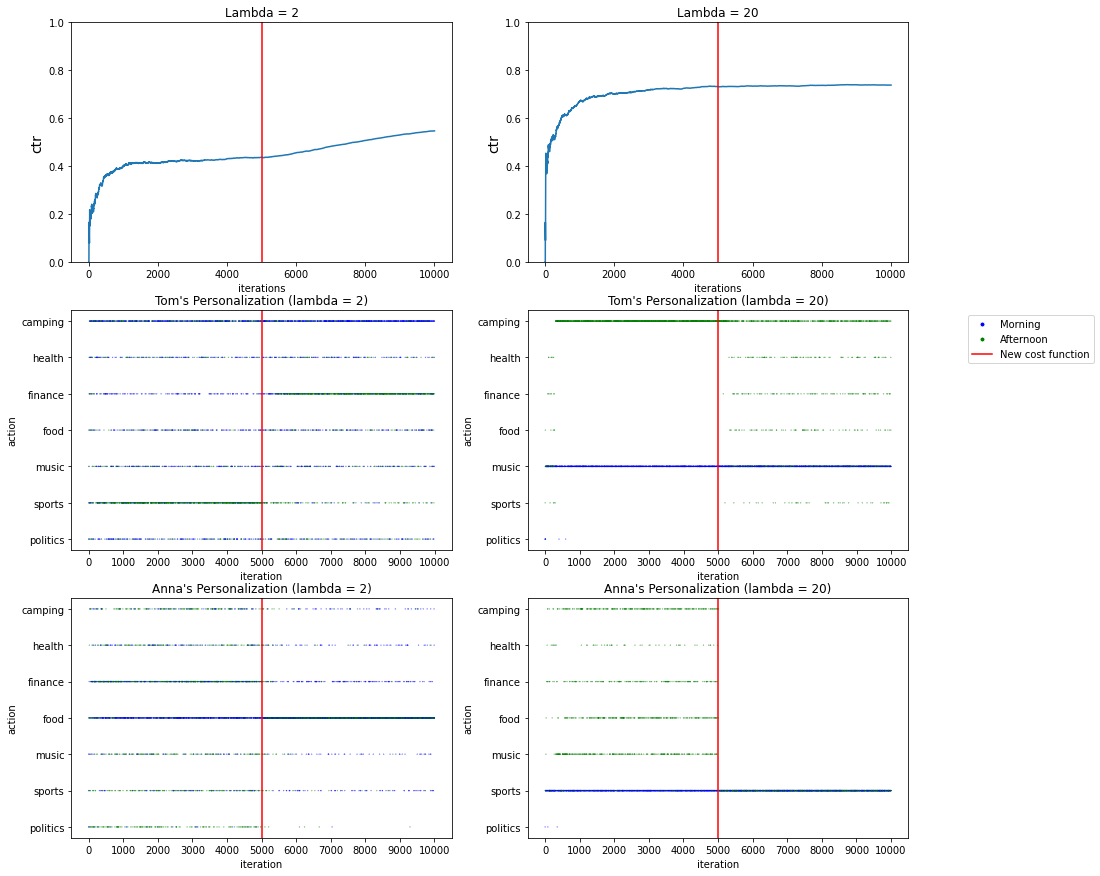

In [41]:
vis_se(ctr_se_low, ctr_se_high, record_info_low, record_info_high, vw_se_low_title, vw_se_high_title, 
       low_lambda, high_lambda, actions, total_iterations)

#### Observation
* As *lambda* approaches 0, it leads towards uniform exploration. In the above case of *lambda*=2, we see greater signs of uniform exploration as compared to when *lambda*=20

### 2 d. Bagging Explorer
* The bagging explorer alogrithm trains *m* different policies with *m* different random sets of the data, and then a policy is chosen at random.
* This helps rule out the bad actions as the probability of choosing those actions are a lot less provided there are enough different policy outcomes to choose from.

In [42]:
def vis_be(ctr1, ctr2, record_info_1, record_info_2, title1, title2, actions, total_iterations):
    plt.figure(figsize=(15,15))
    colours = ListedColormap(['b','g'])
    classes=["morning", "afternoon"]
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), 
                       Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5),
                      Line2D([1], [1], color='red', label='New cost function', markerfacecolor='red', markersize=5)]
    
    plt.subplot(321)
    plt.title(title1)
    plot_ctr(total_iterations, ctr1)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(322)
    plt.title(title2)
    plot_ctr(total_iterations, ctr2)
    plt.axvline(x=total_iterations/2, color='r')
    
    plt.subplot(323)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization ("+title1+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Tom']['iterations'], record_info_1['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Tom']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(324)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Tom's Personalization ("+title2+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_2['Tom']['iterations'], record_info_2['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Tom']['time_of_day']], cmap=colours, s=.05)
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1))
    
    plt.subplot(325)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization ("+title1+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_1['Anna']['iterations'], record_info_1['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_1['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.subplot(326)
    plt.xlabel('iteration')
    plt.ylabel('action')
    plt.title("Anna's Personalization ("+title2+")")
    plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
    plt.yticks(ticks=range(len(actions)), labels=actions)
    plt.axvline(x=total_iterations/2, color='r')
    plt.scatter(record_info_2['Anna']['iterations'], record_info_2['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info_2['Anna']['time_of_day']], cmap=colours, s=.05)
    
    plt.show()

#### Comparing *m* values
* Comparing a low and high *m* value, while keeping the rest of the hyperparameter values intact. RI is set to -1e-07

In [43]:
num_iterations_per_cost_func = 5000
rewards_increment = -1e-07
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

low_m = 2
vw_be_low = pyvw.vw("--cb_explore_adf -q UA --bag "+str(low_m))
ctr_be_low, record_be_low = run_simulation_with_rewards_incrementer(vw_be_low, num_iterations_per_cost_func, users, 
                                                              times_of_day, actions, cost_functions, rewards_increment)
vw_be_low_title = "m = "+str(low_m)

high_m = 100
vw_be_high = pyvw.vw("--cb_explore_adf -q UA --bag "+str(high_m))
ctr_be_high, record_be_high = run_simulation_with_rewards_incrementer(vw_be_high, num_iterations_per_cost_func, users, 
                                                              times_of_day, actions, cost_functions, rewards_increment)
vw_be_high_title = "m = "+str(high_m) 


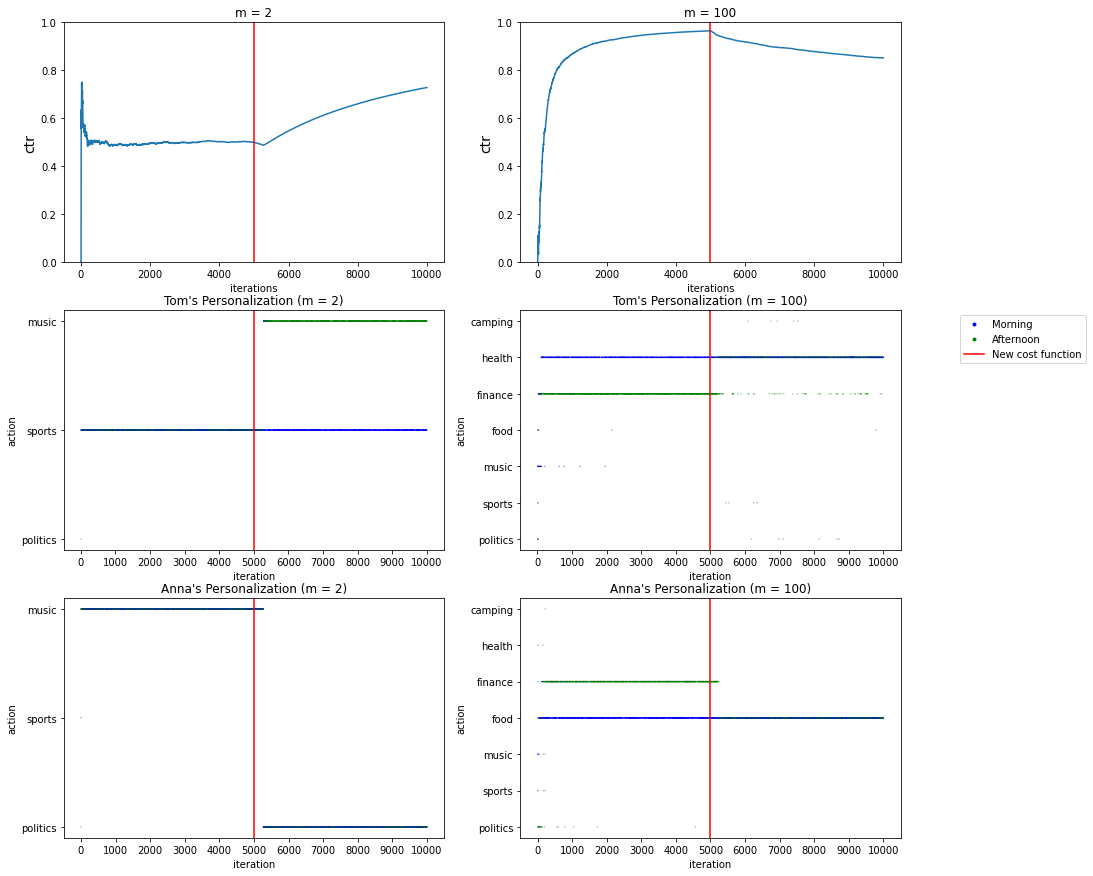

In [44]:
vis_be(ctr_be_low, ctr_be_high, record_be_low, record_be_high, vw_be_low_title, vw_be_high_title, actions, total_iterations)

#### Observations
* With a lower *m* value, the probability of finding a policy with the optimal outcome reduces since the number of policies available from which the algorithm has to choose from is smaller. 